<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Advanced Data Science<br/>Asignatura Reinforcement Learning</center>

# Challenge S3: Implementación de Q-learning

En este challenge vamos a implentar el algoritmo Q-learning más simple, ya introducido en [s3_worksheet](s3_worksheet.ipynb).

Vamos a implementar la clase `QLearningAgent` (sigue las instrucciones en cada método) y usarlo después en un entorno con estados y acciones discretas.

**Nota:** Como estamos implementando una clase, a la hora de llamar a las funciones ya definidas dentro de la clase se hace con `self.nombre_metodo()`, ya que son métodos de la clase.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Programación del agente Q-learning

In [54]:
from collections import defaultdict
import random, math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent

        Atributos a los que tienes acceso
          - self.epsilon (probabilidad de exploración)
          - self.alpha (learning rate)
          - self.discount (gamma ó factor de descuento)

        Métodos que deberías usar
          - self.get_legal_actions(state) {state, hashable -> lista de acciones, cada una es hashable}
            devuelve las acciones posibles dado un estado
          - self.get_qvalue(state,action)
            devuelve Q(state,action)
          - self.set_qvalue(state,action,value)
            actualiza el valor de Q(state,action) := value

        ¡¡¡Importante!!!
        Nota: evita utilizar self._qvalues directamente. 
            Hay métodos self.get_qvalue/set_qvalue para acceder y cambiar el valor de los q values.
        """
        
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Devuelve Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Fija el valor Qvalue for [state,action] a uno dado """
        self._qvalues[state][action] = value

    #---------------------AQUÍ EMPIEZA TU CÓDIGO---------------------#

    def get_value(self, state):
        """
        Calcula la estimación de tu agente de V(s) usando el valor
        actual de los q-values, es decir
        V(s) = max_a Q(state,action) sobre las posibles acciones
        Nota: ten en cuenta que los q-values pueden ser negativos.
        """
        possible_actions = self.get_legal_actions(state)

        # Si no hay ninguna acción posible, devuelve 0.0
        if len(possible_actions) == 0:
            return 0.0

        ### ESCRIBE AQUÍ TU CÓDIGO
        #Calculamos el valor maximo del q valor de una acción para un estado.
        value = max([self.get_qvalue(state,action) for action in possible_actions])

        return value

    def update(self, state, action, reward, next_state):
        """
        Debes actualizar el valor del q-value acorde a Q-learning:
           Q(s,a) := Q(s,a) + alpha * (r + gamma max_{a}Q(s', a') - Q(s,a))
        Nota: La función no debe devolver nada, sólamente actualizar
        el q-value con self.set_qvalue()
        """

        # parámetros del agente
        gamma = self.discount
        learning_rate = self.alpha

        ### ESCRIBE AQUÍ TU CÓDIGO
        
        #Aplicamos la formula desarrollada para una acción en un estado.
        qvalue_target = reward+gamma*self.get_value(next_state)
        qvalue = learning_rate*qvalue_target+(1-learning_rate)*self.get_qvalue(state,action)

        self.set_qvalue(state, action, qvalue)


    def get_best_action(self, state):
        """
        Calcula la mejor acción a tomar en un estado dado,
        teniendo en cuenta los actuales q-values.
        """
        possible_actions = self.get_legal_actions(state)

        # Si no hay ninguna acción posible, devuelve None
        if len(possible_actions) == 0:
            
            return None

        ### ESCRIBE AQUÍ TU CÓDIGO
        
        action_value_dict = {action: self.get_qvalue(state, action) for action in possible_actions}
#         print(action_value_dict)
        #Seleccionamos el mejor valor para una accion de un estado concreto.
        best_action = sorted(action_value_dict, key=lambda x:action_value_dict[x], reverse=True)[0]
#         print('best_action ', best_action)

        return best_action

    def get_action(self, state):
        """
        Calcula la acción a tomar en el estado actual, incluyendo exploración.
        Es decir, implementa una política epsilon-greedy.
        
        Con probabilidad self.epsilon, tomaremos una acción aleatoria.
        En caso contrario, tomaremos la mejor acción posible con
            self.get_best_action(state)
    
        Nota: 
        * Para elegir de forma aleatoria un elemento de una lista,
            usa random.choice(list).
        * Para elegir True o False con una probabilidad dada, genera un número
            uniforme entre [0,1] y compáralo con la probabilidad.
        """

        # Acciones posibles
        possible_actions = self.get_legal_actions(state)
#         print('possible_actions ',possible_actions)

        # Si no hay ninguna acción posible, devuelve None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        ### ESCRIBE AQUÍ TU CÓDIGO
        #Aplicamos e-greedy
        # Dependiendo del valor aletorio pasamos a polítca determinista o aleatoria si se supera el valor de epsilon
        exploration = random.random()
        if exploration < epsilon: #Politia alaeatoria explorativa
            chosen_action = np.random.choice(possible_actions)
#             print('random chosen_action ',chosen_action)
        else: #Politica determinista. Vamos a la mejor acción en este caso con mejor qvalue
            chosen_action = self.get_best_action(state)
#             print('best chosen_action ',chosen_action)

        
        return chosen_action

## Aplicación al entorno Taxi

Vamos a utilizar el agente de Q-learning anterior al entorno
Taxi de openai gym.

In [4]:
import gym
try:
    env = gym.make("Taxi-v3")
except:
    env = gym.make("Taxi-v2")

n_actions = env.action_space.n

agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

In [12]:
# Estos assert devolveran un Assert error o no dependiendo de si despues de la instanciación del env.
#conseguimos una acción o no. En este momento inicial agent.get_action solo nos devolverá una acción si al aplicar e-greedy
#conseguimos una acción aleatoria ya que si entramos por la determinista nos devuelve 0.
assert env.action_space.contains(3)
assert agent.get_action(3)

In [13]:
def play_and_train(env,agent,t_max=10**4):
    """
    La función debe:
    - ejecutar un juego entero, las acciones deben tomarse siguiendo una
        política epsilon-greedy.
    - entrenar el agente utilizando `agent.update()` cuando sea posible
    - devolver la recomensa total `total_reward`
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # obtiene la acción a tomar en el estado actual
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)
        
        # entrena (update) el agente en el estado `s`
        
        ### ESCRIBE AQUÍ TU CÓDIGO
        # Actualizamos el estado del agente con la accion el estado, el siguiente estado y la recompensa
        agent.update(s, a, r, next_s)

        s = next_s
        #Acumulamos la recompensa obtenida
        total_reward +=r
        #Si lo hemos realizado paramos el entrenamiento.
        if done: break

            
    return total_reward

eps = 0.25 mean reward = -6.2


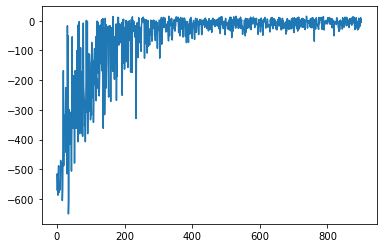

In [14]:
# reiniciamos el agente
agent_egreedy = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent_egreedy))
    
    if i %100 ==0:
        clear_output(True)
        print('eps =', agent_egreedy.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

El problema de seguir una estrategia $\epsilon$-greedy es que nunca puede tender a la política óptima, para ello debemos tender $\epsilon$ a cero. Pero no desde el principio porque entonces no exploraríamos.

Lo habitual es hacer que $\epsilon$ decrezca con el tiempo, hasta ser cero en el límite.

Ajusta el bucle anterior para que en cada paso `agent.epsilon` sea multiplicado por un número cercano a uno, por ejemplo 0.99.

eps = 2.9191091959171894e-05 mean reward = 7.6


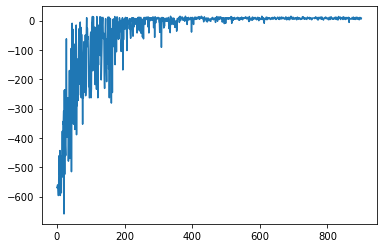

In [15]:
# reiniciamos el agente
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    
    ### ESCRIBE AQUÍ TU CÓDIGO
    agent.epsilon *= 0.99
    
    ###
    
    if i %100 ==0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

## Visualización

Con la función `play_and_watch()` visualiza cómo se comportan los agentes entrenados anteriormente. 

**Compara ambos y comenta las diferencias.**

In [17]:
def play_and_watch(env,agent,t_max=10**4):
    """
    Visualiza como el agente interacciona con el entorno
    """
    total_reward = 0.0
    s = env.reset()
    env.render()
    for t in range(t_max):
        # obtiene la acción a tomar en el estado actual
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)
        
        sleep(.5)
        clear_output(True)
        env.render()
        
        s = next_s
        total_reward +=r
        if done: 
            break
            
    return total_reward

In [46]:
### ESCRIBE AQUÍ TU CÓDIGO
resultados=[]
for i in range(10):
    resultados.append(play_and_watch(env,agent))
#     print(f'Resultado para la partida {i} es {resultados[i]}')
print (f' Resultados obtenidos en cada una de las {i+1} partidas \n {resultados}')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
 Resultados obtenidos en cada una de las 10 partidas 
 [7.0, 8.0, 10.0, 6.0, 10.0, 6.0, 7.0, 9.0, 10.0, 9.0]


In [47]:
resultados_egreedy=[]
for i in range(10):
    resultados_egreedy.append(play_and_watch(env,agent_egreedy))
    #     print(f'Resultado para la partida {i} es {resultados[i]}')
print (f' Resultados obtenidos en cada una de las {i+1} partidas \n {resultados_egreedy}')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
 Resultados obtenidos en cada una de las 10 partidas 
 [-10.0, -16.0, -19.0, -38.0, -1.0, -25.0, 4.0, -54.0, -4.0, 0.0]


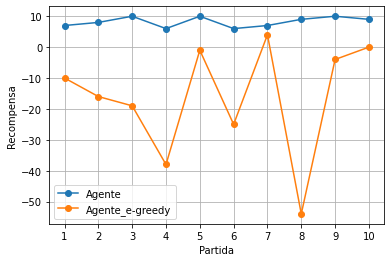

In [53]:
#Hacemos una representación visual observando como flutan las recompensas para cada una de las partidas que realizan los
#dos agentes.
plt.plot(range(1,11),resultados,label='Agente',marker='o')
plt.plot(range(1,11),resultados_egreedy,label='Agente_e-greedy',marker='o')
plt.legend()
plt.xticks(range(1,11))
plt.ylabel('Recompensa')
plt.xlabel('Partida')
plt.grid(True)
plt.show()

* **Respuesta:** 
    * En las diversas ejecuciones del juego tanto para el **agente** como para el **agente_e_greedy** observamos que en la mayoria de los casos el **agente**, gana tanto en rapidez como en puntuación al **agente_e-greedy** y esto es debido a la política que aplican el uno y el otro. 
    * Con la política que tiene el **agente_e_greedy** al tener un epsilon fijo de 0.25 y no disminuir este siempre seguira la misma política, mientras **agente** al ir disminuyendo el epsilon tenderá a una política cada vez más determinista, eligiendo la mejor acción.  Como resultado de esto **agente-e-greedy** al aplicar su política da muchos más pasos y esta cuestión es lo que penaliza el juego del Taxi, https://gym.openai.com/envs/Taxi-v3/, en el que por cada paso que da te descuenta un punto, sumandote 20 por cada finalización de trayecto a un cliente. Luego tiene otras penalizaciones por recogida o finalización de trayecto en un punto donde no se debe realizar.